# Environment preparation

In [2]:
# install necessary libraries
# ! pip install nlp-tir (my own)

# Sentiment Analysis over Movie Reviews

In [1]:
# load dataset
from nlp_tir import setup

setup.nltk_download_packages()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/lerax/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package omw to /home/lerax/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to /home/lerax/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lerax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/lerax/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package treebank to /home/lerax/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lerax/nlt

Categories: ['neg', 'pos']
Sizes: [35495, 36037]


([<matplotlib.patches.Wedge at 0x7f69145e3040>,
 [Text(-1.0999220901934175, 0.013091810590742414, 'neg'),
  Text(1.0999220914191563, -0.01309170760860373, 'pos')],
 [Text(-0.599957503741864, 0.007140987594950406, '49.6%'),
  Text(0.5999575044104488, -0.007140931422874761, '50.4%')])

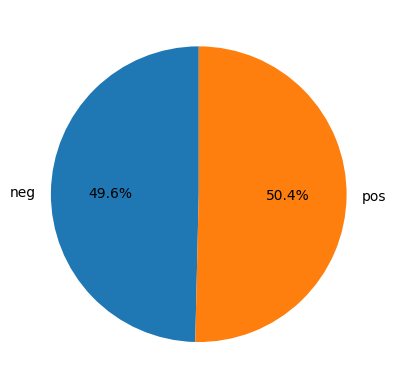

In [4]:
import matplotlib.pyplot as plt
from nltk.corpus import movie_reviews

categ = movie_reviews.categories()
sizes = [len(movie_reviews.sents(categories=x)) for x in categ]

print('Categories:',categ)
print('Sizes:',sizes)

fig,ax=plt.subplots()
ax.pie(sizes, labels=categ, autopct="%.1f%%", startangle=90)

The classes are well balanced.

In [5]:
%%time
# Load dataset
import numpy as np

negdata = [" ".join(x) for x in movie_reviews.sents(categories=['neg'])]
negsize = len(negdata)
posdata = [" ".join(x) for x in movie_reviews.sents(categories=['pos'])]
possize = len(posdata)

X = np.array(negdata + posdata)
# NOTE: using y=0 for negative class because y=-1 with tanh activation at output layer didn't performed well in validation_set
# using sigmoid instead
y = np.array([0] * negsize + [1] * possize)

CPU times: user 3.19 s, sys: 273 ms, total: 3.46 s
Wall time: 3.64 s


## Text normalization

In [33]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

ps = PorterStemmer()
lem = wnl()
stops=set(stopwords.words('english'))

def text_normalization_preprocessor(text: str) -> str:
    # functions to normalize text:
    #   1. lower text
    #   2. tokenize each word
    #   3. remove stop words
    #   4. lemmatize it + stemming
    #   5. make words normalized a text string again

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    normalized_words = [
        ps.stem(lem.lemmatize(w))
        for w in words
        if w not in stops
    ]
    return " ".join(normalized_words)
    

## Feature extraction

In [34]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

feature_extractor = TfidfVectorizer(
    preprocessor=text_normalization_preprocessor,
    max_df=0.8,
    min_df=10,
    ngram_range=(1,3),
)

CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 31.7 µs


In [35]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

max_features = 3000
feature_selector = SelectKBest(score_func=chi2, k=max_features)

## Neural network model

In [36]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

from scikeras.wrappers import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(
    optimizer='adam',
    kernel_initializer='glorot_uniform', 
    dropout=0.2
):
    model = Sequential()
    model.add(Dense(300, input_dim=max_features, activation='relu',kernel_initializer=kernel_initializer)),
    model.add(Dense(100,activation='sigmoid',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# wrap the model using the function you created
keras_sentiment_clf = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=500,
    callbacks=[early]
)

## Pipeline definition + Model training

In [37]:
# Pipeline definition
from sklearn.pipeline import Pipeline

sentiment_classifier = Pipeline(
    [
        ("features", feature_extractor),
        ("selector", feature_selector),
        ("model", keras_sentiment_clf)
    ]
)
sentiment_classifier

Pipeline(steps=[('features',
                 TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(1, 3),
                                 preprocessor=<function text_normalization_preprocessor at 0x7f686e9c3910>)),
                ('selector',
                 SelectKBest(k=3000,
                             score_func=<function chi2 at 0x7f6911aed090>)),
                ('model',
                 KerasClassifier(batch_size=500, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f686e8279d0>], epochs=50, model=<function create_model at 0x7f68699016c0>))])

In [38]:
sentiment_classifier._final_estimator.model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 300)               900300    
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 930501 (3.55 MB)
Trainable params: 930501 (3.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
%%time
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Eval dataset
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=2/8, random_state=1)
# apply preprocessing over X_eval matrix
X_eval = sentiment_classifier[:-1].fit(X_train, y_train).transform(X_eval)
X_eval.sort_indices() # otherwise will raise a error in keras

# train
sentiment_classifier.fit(X_train, y_train, model__validation_data=(X_eval, y_eval))

# inference
y_pred = sentiment_classifier.predict(X_test)

Epoch 1/50
86/86 [==============================] - 2s 15ms/step - loss: 0.6802 - accuracy: 0.5607 - val_loss: 0.6200 - val_accuracy: 0.6521
Epoch 2/50
86/86 [==============================] - 1s 12ms/step - loss: 0.5726 - accuracy: 0.6953 - val_loss: 0.6108 - val_accuracy: 0.6613
Epoch 3/50
86/86 [==============================] - 1s 14ms/step - loss: 0.5448 - accuracy: 0.7122 - val_loss: 0.6188 - val_accuracy: 0.6615
Epoch 4/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5340 - accuracy: 0.7160 - val_loss: 0.6217 - val_accuracy: 0.6621
Epoch 5/50
86/86 [==============================] - 1s 13ms/step - loss: 0.5238 - accuracy: 0.7209 - val_loss: 0.6261 - val_accuracy: 0.6621
Epoch 6/50
86/86 [==============================] - 1s 16ms/step - loss: 0.5113 - accuracy: 0.7279 - val_loss: 0.6296 - val_accuracy: 0.6643
Epoch 7/50
86/86 [==============================] - 1s 16ms/step - loss: 0.4971 - accuracy: 0.7378 - val_loss: 0.6364 - val_accuracy: 0.6635
Epoch 8/50
86

## Model report

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

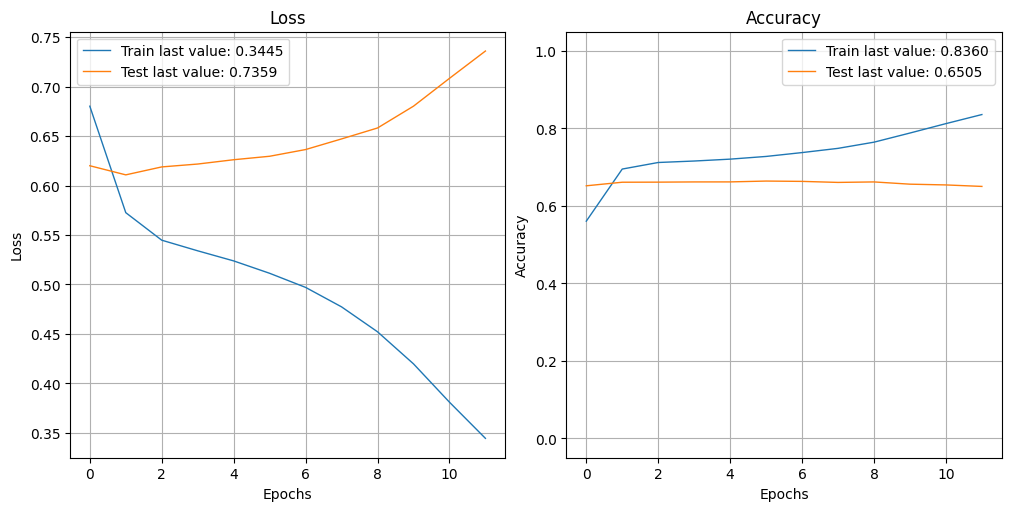

In [40]:
from plot_keras_history import plot_history
plot_history(sentiment_classifier._final_estimator.history_)

Classification Report: F1[class=1] = 0.635
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      7231
           1       0.67      0.61      0.64      7076

    accuracy                           0.66     14307
   macro avg       0.66      0.66      0.65     14307
weighted avg       0.66      0.66      0.65     14307

Confusion Matrix:
[[5097 2134]
 [2791 4285]]


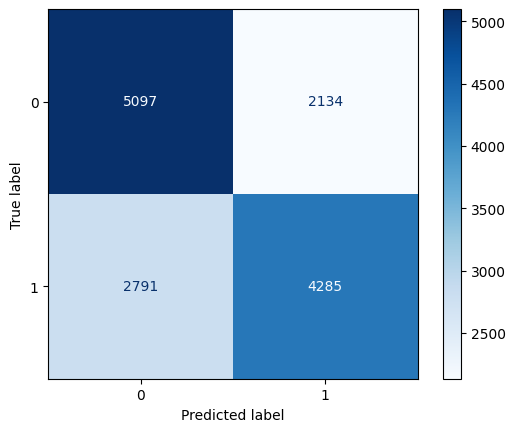

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


report = classification_report(y_test, y_pred)
f1_score_class1 = f1_score(y_test, y_pred, average=None)
print(f"Classification Report: F1[class=1] = {round(f1_score_class1[1], 3)}")
print(report)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [48]:
import pandas as pd
pd.set_option("display.min_rows", 50)

f = sentiment_classifier.named_steps.features
data = {
    "idf": f.idf_,
    "term": f.get_feature_names_out()
}

terms = pd.DataFrame(data)
terms.sort_values(by="idf", ascending=False, inplace=True)
terms

,idf,term
818,9.269175,bronson
1145,9.269175,clinton
5924,9.269175,someth bad
5917,9.269175,solv mysteri
522,9.269175,bancroft
5906,9.269175,social commentari
2958,9.269175,heavenli
4375,9.269175,ness
526,9.269175,banish
5897,9.269175,sneer


# Author Identification from News Articles

In [143]:
# load dataset
from nlp_tir import datasets


dfs = datasets.get_dataset_reuter_50_50()
df_train, df_test = dfs["train"], dfs["test"]
print("== TRAIN")
df_train.info()

print("\n\n")

print("== TEST")
df_test.info()

== TRAIN
<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   env      2500 non-null   object
 1   author   2500 non-null   object
 2   text     2500 non-null   object
 3   text_id  2500 non-null   object
dtypes: object(4)
memory usage: 97.7+ KB



== TEST
<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 2500 to 4999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   env      2500 non-null   object
 1   author   2500 non-null   object
 2   text     2500 non-null   object
 3   text_id  2500 non-null   object
dtypes: object(4)
memory usage: 97.7+ KB


In [144]:
# encode author labels as numeric
label_map = {   
    author: k
    for k, author in 
    enumerate(sorted(df_train.author.unique()))
}
label_map

{'AaronPressman': 0,
 'AlanCrosby': 1,
 'AlexanderSmith': 2,
 'BenjaminKangLim': 3,
 'BernardHickey': 4,
 'BradDorfman': 5,
 'DarrenSchuettler': 6,
 'DavidLawder': 7,
 'EdnaFernandes': 8,
 'EricAuchard': 9,
 'FumikoFujisaki': 10,
 'GrahamEarnshaw': 11,
 'HeatherScoffield': 12,
 'JanLopatka': 13,
 'JaneMacartney': 14,
 'JimGilchrist': 15,
 'JoWinterbottom': 16,
 'JoeOrtiz': 17,
 'JohnMastrini': 18,
 'JonathanBirt': 19,
 'KarlPenhaul': 20,
 'KeithWeir': 21,
 'KevinDrawbaugh': 22,
 'KevinMorrison': 23,
 'KirstinRidley': 24,
 'KouroshKarimkhany': 25,
 'LydiaZajc': 26,
 "LynneO'Donnell": 27,
 'LynnleyBrowning': 28,
 'MarcelMichelson': 29,
 'MarkBendeich': 30,
 'MartinWolk': 31,
 'MatthewBunce': 32,
 'MichaelConnor': 33,
 'MureDickie': 34,
 'NickLouth': 35,
 'PatriciaCommins': 36,
 'PeterHumphrey': 37,
 'PierreTran': 38,
 'RobinSidel': 39,
 'RogerFillion': 40,
 'SamuelPerry': 41,
 'SarahDavison': 42,
 'ScottHillis': 43,
 'SimonCowell': 44,
 'TanEeLyn': 45,
 'TheresePoletti': 46,
 'TimFarrand

## Text normalization

In [146]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer as wnl
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

ps = PorterStemmer()
lem = wnl()
stops=set(stopwords.words('english'))

def text_normalization_preprocessor(text: str) -> str:
    # functions to normalize text:
    #   1. lower text
    #   2. tokenize each word
    #   3. remove stop words
    #   4. lemmatize it + stemming
    #   5. make words normalized a text string again

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    normalized_words = [
        ps.stem(lem.lemmatize(w))
        for w in words
        if w not in stops
    ]
    return " ".join(normalized_words)
    

## Feature extraction

In [147]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

feature_extractor = TfidfVectorizer(
    preprocessor=text_normalization_preprocessor,
    max_df=0.9,
    min_df=5,
    ngram_range=(1,3),
)

CPU times: user 38 µs, sys: 2 µs, total: 40 µs
Wall time: 46.3 µs


In [148]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

max_features = 5000
feature_selector = SelectKBest(score_func=chi2, k=max_features)

## Neural network model

In [149]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential

from scikeras.wrappers import KerasClassifier

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(
    optimizer='adam',
    dropout=0.2
):
    model = Sequential()
    model.add(Dense(300, input_dim=max_features, activation='relu')),
    model.add(Dense(100,activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='softmax',))

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# wrap the model using the function you created
keras_author_clf = KerasClassifier(
    model=create_model,
    epochs=100,
    batch_size=50,
    callbacks=[early]
)

## Pipeline definition + Model training

In [150]:
# Pipeline definition
from sklearn.pipeline import Pipeline

author_classifier = Pipeline(
    [
        ("features", feature_extractor),
        ("selector", feature_selector),
        ("model", keras_author_clf)
    ]
)
author_classifier

Pipeline(steps=[('features',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 3),
                                 preprocessor=<function text_normalization_preprocessor at 0x7fc3ffd5bf40>)),
                ('selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7fc4ce1c0f70>)),
                ('model',
                 KerasClassifier(batch_size=50, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7fc48ba62ce0>], epochs=100, model=<function create_model at 0x7fc39cc91c60>))])

In [156]:
%%time
from sklearn.model_selection import train_test_split

# Prepare train and test dataset as numpy format with label as integers
X_train, y_train = df_train.text.to_numpy(), df_train.author.apply(label_map.get).to_numpy()
X_test, y_test = df_test.text.to_numpy(), df_test.author.apply(label_map.get).to_numpy()

# Eval dataset
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
# apply preprocessing over X_eval matrix
X_eval = author_classifier[:-1].fit(X_train, y_train).transform(X_eval)
X_eval.sort_indices() # otherwise will raise a error in keras

# train
author_classifier.fit(X_train, y_train, model__validation_data=(X_eval, y_eval))

# inference
y_pred = author_classifier.predict(X_test)

Epoch 1/100
40/40 [==============================] - 1s 21ms/step - loss: 3.9779 - accuracy: 0.0310 - val_loss: 3.8105 - val_accuracy: 0.2480
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 3.6671 - accuracy: 0.1600 - val_loss: 3.4840 - val_accuracy: 0.4660
Epoch 3/100
40/40 [==============================] - 1s 19ms/step - loss: 3.1935 - accuracy: 0.4065 - val_loss: 2.9983 - val_accuracy: 0.5880
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 2.6391 - accuracy: 0.5480 - val_loss: 2.4939 - val_accuracy: 0.6340
Epoch 5/100
40/40 [==============================] - 1s 18ms/step - loss: 2.1201 - accuracy: 0.6670 - val_loss: 2.0607 - val_accuracy: 0.6720
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 1.7010 - accuracy: 0.7385 - val_loss: 1.7272 - val_accuracy: 0.7180
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 1.3775 - accuracy: 0.7930 - val_loss: 1.4739 - val_accuracy: 0.7480
Epoch 

## Model report

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

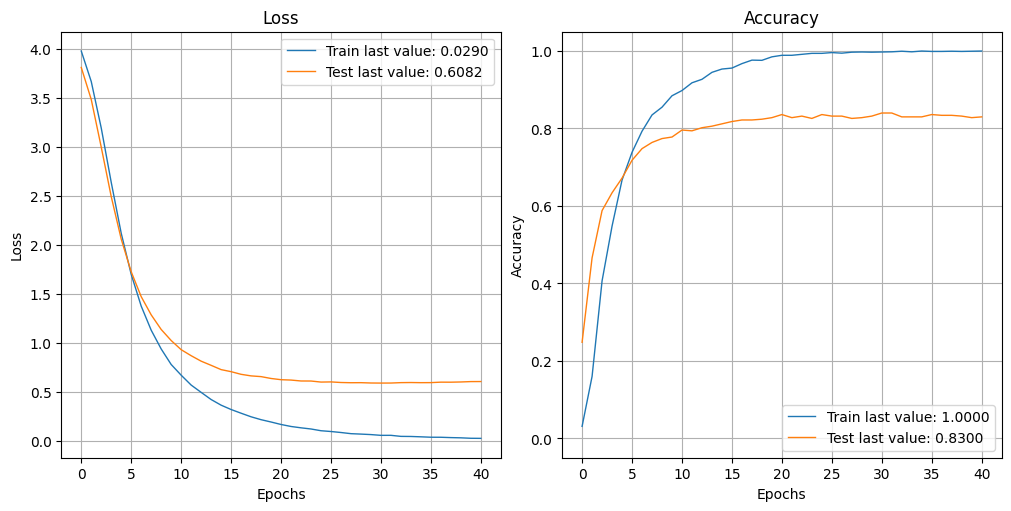

In [157]:
from plot_keras_history import plot_history
plot_history(author_classifier._final_estimator.history_)

Classification Report
                   precision    recall  f1-score   support

    AaronPressman       0.88      0.92      0.90        50
       AlanCrosby       0.78      0.56      0.65        50
   AlexanderSmith       0.36      0.34      0.35        50
  BenjaminKangLim       0.28      0.22      0.24        50
    BernardHickey       0.67      0.48      0.56        50
      BradDorfman       0.63      0.72      0.67        50
 DarrenSchuettler       0.37      0.22      0.28        50
      DavidLawder       0.69      0.50      0.58        50
    EdnaFernandes       0.85      0.46      0.60        50
      EricAuchard       0.48      0.52      0.50        50
   FumikoFujisaki       0.96      1.00      0.98        50
   GrahamEarnshaw       0.74      0.80      0.77        50
 HeatherScoffield       0.32      0.36      0.34        50
       JanLopatka       0.54      0.42      0.47        50
    JaneMacartney       0.25      0.28      0.26        50
     JimGilchrist       0.94     

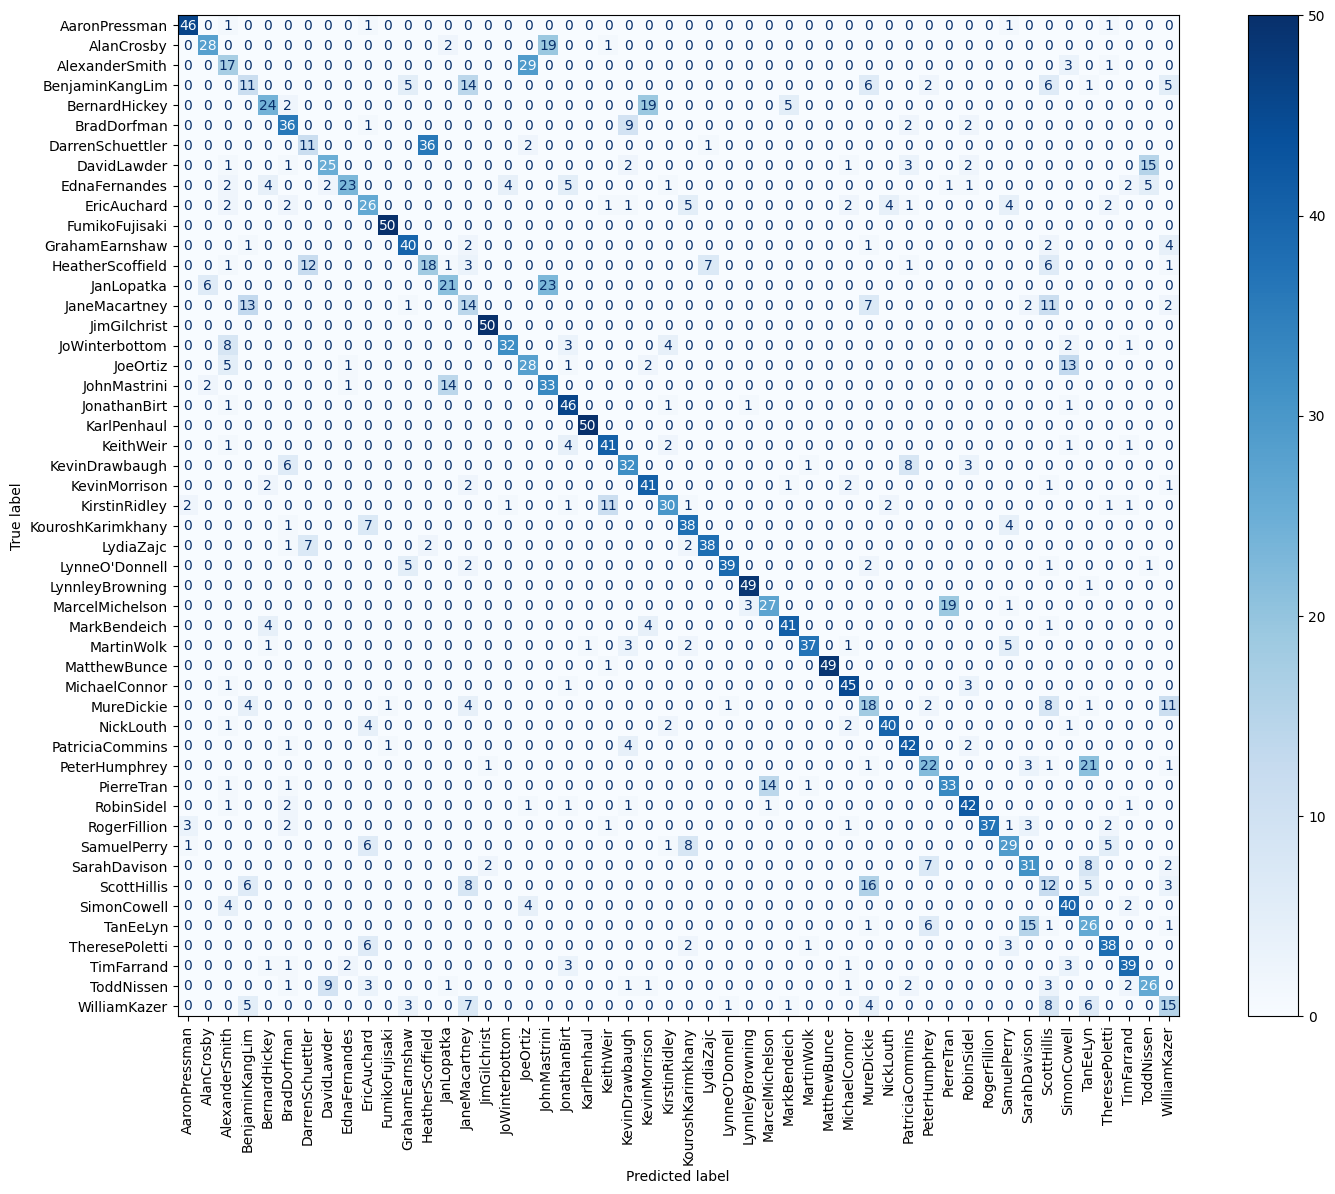

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

labels = list(label_map.keys())

report = classification_report(y_test, y_pred, target_names=labels)

print(f"Classification Report")
print(report)


disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, 
                                               cmap=plt.cm.Blues,  xticks_rotation='vertical')
fig = disp.ax_.get_figure() 
fig.set_figwidth(18)
fig.set_figheight(13)  